In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List
from moseq2_nlp.models import DocumentEmbedding
from moseq2_nlp.data import load_groups, get_transition_representation, get_transition_representations_n, sample_markov_chain
from moseq2_nlp.train import train_regressor, train_svm
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import lil_matrix
import pdb
import os
from tqdm import tqdm
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
np.random.rand(5,5)

array([[0.58443151, 0.14538166, 0.70423002, 0.58370795, 0.35969116],
       [0.24640227, 0.08094485, 0.28149423, 0.40087238, 0.22622525],
       [0.1212442 , 0.18304144, 0.52180859, 0.66023218, 0.28600931],
       [0.65876832, 0.75981351, 0.69341306, 0.04524983, 0.53383397],
       [0.35949381, 0.7563064 , 0.16637818, 0.26798459, 0.47059912]])

# Synthetic data

What are you doing here....?

## Synthesize data

In [3]:
data_dir = '/cs/labs/mornitzan/ricci/data/abraira'
data_name = '2020-11-10_Celsr3_R774H'
model_file = os.path.join(data_dir, data_name, 'robust_septrans_model_1000.p')
index_file = os.path.join(data_dir, data_name, 'gender-genotype-index.yaml')

# Get nth order transitions (usages, transitions, 3grams, etc.)
n=6
num_transitions=100
max_syllable=50
transition_matrices, out_groups = get_transition_representations_n(model_file, index_file, n,
                                                                   num_transitions, normalize='row', max_syllable=max_syllable)

Loading raw data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.03it/s]


Getting 4-grams.


98it [00:38,  2.55it/s]


> /cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py(171)get_transition_representations_n()
    169         transition_matrices.append(tmx)
    170     pdb.set_trace()
--> 171     tm_array = np.array(transition_matrices)
    172     #top_transitions = np.argsort(tm_array.mean(0))[-num_transitions:]
    173     #truncated_tm_vals = tm_array[:,top_transitions]

ipdb> n
> /cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py(175)get_transition_representations_n()
    173     #truncated_tm_vals = tm_array[:,top_transitions]
    174 
--> 175     return tm_array, out_groups
    176 
    177 def get_embedding_representation(model_file: str, index_file: str, group_map: Dict[str, str], emissions: bool, bad_syllables: List[int], dm: Literal[0,1,2], embedding_dim: int, embedding_window: int, embedding_epochs: int, min_count: int, model_dest: str, ablation: str, phrase_path: str):

ipdb> tm_array.shape
(98, 70, 70, 70, 70)
ipdb> c


In [4]:
unique_groups = []
for group in out_groups:
    if group not in unique_groups:
        unique_groups.append(group)
        
labels = []
for group in out_groups:
    labels.append(unique_groups.index(group))

In [5]:
num_syllables_range = [10000,15000]
all_synthesized_data = []

# NOTE: Check Markov sampling. Make sure that the 0s case makes sense...
# NOTE: Current output for get_transition_representations_n does NOT work for markov sampling. Need full mx!

for l, tmx in tqdm(enumerate(transition_matrices)):
    num_syllables = np.random.randint(num_syllables_range[0], num_syllables_range[1])
    all_synthesized_data.append(sample_markov_chain(tmx,num_syllables))

documents = [TaggedDocument(sent, [i]) for i, sent in enumerate(all_synthesized_data)]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:198: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
98it [00:32,  2.97it/s]


## Train on synthetic data

In [6]:
dim = 300 #max_syllable # Dimension of embedding space
window = 1 # Window size for context (this is left and right, so total size is 2*window)

# Initialize and train two models on the documents. Embeddings will be averaged, which is standard. 
# Note: min_count = <min_count> omits words with usages less than <min_count>
print('Training dm=1')
model1 = Doc2Vec(documents, dm=1, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Training dm=0')
model2 = Doc2Vec(documents, dm=0, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Done')

Training dm=1
Training dm=0
Done


In [7]:
# Infer embeddings per document per model and then average. 
E1 = [model1.infer_vector(sent) for sent in all_synthesized_data]
E2 = [model2.infer_vector(sent) for sent in all_synthesized_data]
E = [.5 * (em1 + em2) for (em1, em2) in zip(E1, E2)]

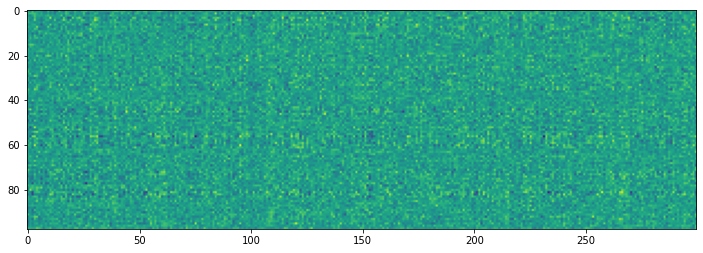

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(np.array(E))
plt.show()

## Classify

In [9]:
classifier = 'logistic_regression'
scoring = 'accuracy'
K = 1
penalty = 'l2'
num_c = 11
seed = 0

print('Training classifier')
if classifier == 'logistic_regression':
    best_C, scores = train_regressor(E, labels, K, scoring, penalty, num_c, seed)
elif classifier == 'svm':
    best_C, scores = train_svm(E, labels, kernel, K, scoring, penalty, num_c, seed)
    
print(best_C, np.max(scores.mean((0,1))))

Training classifier
1000.0 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1

In [10]:
print(np.max(best_score.mean((0,1))))

0.5612244897959183


In [2]:
min_n, max_n = 1,6
min_k, max_k = 1,3
acc_mx = np.zeros((max_n, max_k))
num_syllables_range = [10000,15000]

data_dir = '/cs/labs/mornitzan/ricci/data/abraira'
data_name = '2020-11-10_Celsr3_R774H'
model_file = os.path.join(data_dir, data_name, 'robust_septrans_model_1000.p')
index_file = os.path.join(data_dir, data_name, 'gender-genotype-index.yaml')

# Get nth order transitions (usages, transitions, 3grams, etc.)
n=4
num_transitions=100
max_syllable=25
dm=2
embedding_dim=300
embedding_epochs=50
min_count = 1
scoring = 'accuracy'
K = 1
penalty = 'l2'
num_c = 11
seed = 0

pbar = tqdm((max_n - min_n)*(max_k - min_k), position=0, leave=True)

0it [00:00, ?it/s]

In [ ]:
for n in range(min_n,max_n + 1):
    for k in range(min_k,max_k + 1):
        print(f'Running order {n}, window {k}.')
        embedding_window = k
        
        # synthesize data
        transition_matrices, out_groups = get_transition_representations_n(model_file, index_file, n,
                                                                   num_transitions, normalize='row', max_syllable=max_syllable)
        
        all_synthesized_data = []
        for l, tmx in tqdm(enumerate(transition_matrices)):
            num_syllables = np.random.randint(num_syllables_range[0], num_syllables_range[1])
            all_synthesized_data.append(sample_markov_chain(tmx,num_syllables))
        
        unique_groups = []
        for group in out_groups:
            if group not in unique_groups:
                unique_groups.append(group)

        labels = []
        for group in out_groups:
            labels.append(unique_groups.index(group))
        
        # get embeddings
        de = DocumentEmbedding(dm=dm, embedding_dim=embedding_dim, embedding_window=embedding_window,
                               embedding_epochs=embedding_epochs,min_count=min_count)
        print('Learning embeddings...')
        E = np.array(de.fit_predict(all_synthesized_data))
        
        print('Classifying...')
        # classify
        best_C, scores = train_regressor(E, labels, K, scoring, penalty, num_c, seed)
        
        print('Updating...')
        # store
        acc_mx[n-1,k-1] = np.max(scores.mean((0,1)))
        pbar.update(1)
pbar.close()

Running order 1, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.24it/s]


Getting 1-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 183.01it/s]
39it [00:00, 192.13it/s]
59it [00:00, 193.58it/s]
98it [00:00, 195.14it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])

1it [00:00,  6.07it/s]
2it [00:00,  6.29it/s]
3it [00:00,  6.41it/s]
4it [00:00,  6.68it/s]
5it [00:00,  6.47it/s]
6it [00:00,  6.8

Learning embeddings...
Classifying...


1it [02:14, 134.43s/it]

Updating...
Running order 1, window 2.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.67it/s]


Getting 1-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

21it [00:00, 205.12it/s]
42it [00:00, 202.00it/s]
63it [00:00, 201.85it/s]
98it [00:00, 202.17it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])

1it [00:00,  7.83it/s]
2it [00:00,  7.54it/s]
3it [00:00,  7.82it/s]
4it [00:00,  7.14it/s]
5it [00:00,  7.54it/s]
6it [00:00,  7.2

Learning embeddings...
Classifying...


2it [03:53, 113.85s/it]

Updating...
Running order 1, window 3.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.65it/s]


Getting 1-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

21it [00:00, 201.73it/s]
42it [00:00, 199.46it/s]
62it [00:00, 198.96it/s]
98it [00:00, 199.14it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])

1it [00:00,  6.85it/s]
2it [00:00,  7.55it/s]
3it [00:00,  7.07it/s]
4it [00:00,  6.81it/s]
5it [00:00,  6.61it/s]
6it [00:00,  6.9

Learning embeddings...
Classifying...


3it [05:47, 113.87s/it]

Updating...
Running order 2, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.31it/s]


Getting 2-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 185.67it/s]
38it [00:00, 184.38it/s]
57it [00:00, 182.46it/s]
77it [00:00, 185.06it/s]
98it [00:00, 184.24it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


4it [07:21, 105.79s/it]

Updating...
Running order 2, window 2.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.48it/s]


Getting 2-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

20it [00:00, 191.08it/s]
40it [00:00, 188.42it/s]
59it [00:00, 186.71it/s]
78it [00:00, 187.91it/s]
98it [00:00, 188.16it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


5it [09:02, 104.31s/it]

Updating...
Running order 2, window 3.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 25.91it/s]


Getting 2-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 188.51it/s]
38it [00:00, 186.33it/s]
57it [00:00, 183.03it/s]
77it [00:00, 185.71it/s]
98it [00:00, 185.58it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


6it [10:52, 106.28s/it]

Updating...
Running order 3, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.83it/s]


Getting 3-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 180.99it/s]
38it [00:00, 177.23it/s]
56it [00:00, 175.35it/s]
74it [00:00, 176.81it/s]
98it [00:00, 176.85it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


7it [12:30, 103.28s/it]

Updating...
Running order 3, window 2.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.49it/s]


Getting 3-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 182.09it/s]
38it [00:00, 179.62it/s]
56it [00:00, 176.86it/s]
75it [00:00, 178.30it/s]
98it [00:00, 178.33it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


8it [14:16, 104.13s/it]

Updating...
Running order 3, window 3.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.21it/s]


Getting 3-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

19it [00:00, 181.72it/s]
38it [00:00, 178.75it/s]
56it [00:00, 176.43it/s]
75it [00:00, 177.78it/s]
98it [00:00, 175.97it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:207: FutureWarning: Using a non-tuple seque

Learning embeddings...
Classifying...


9it [16:08, 106.64s/it]

Updating...
Running order 4, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 25.96it/s]


Getting 4-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

14it [00:00, 137.62it/s]
28it [00:00, 133.83it/s]
42it [00:00, 132.13it/s]
56it [00:00, 130.85it/s]
70it [00:00, 130.93it/s]
84it [00:00, 131.33it/s]
98it [00:00, 131.68it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/d

Learning embeddings...
Classifying...


10it [18:20, 114.69s/it]

Updating...
Running order 4, window 2.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.01it/s]


Getting 4-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

14it [00:00, 135.99it/s]
28it [00:00, 132.62it/s]
42it [00:00, 130.72it/s]
56it [00:00, 129.41it/s]
70it [00:00, 130.82it/s]
84it [00:00, 130.34it/s]
98it [00:00, 130.62it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/d

Learning embeddings...
Classifying...


11it [20:30, 119.23s/it]

Updating...
Running order 4, window 3.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.72it/s]


Getting 4-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

14it [00:00, 138.28it/s]
28it [00:00, 135.18it/s]
42it [00:00, 132.95it/s]
56it [00:00, 131.76it/s]
70it [00:00, 132.65it/s]
84it [00:00, 132.76it/s]
98it [00:00, 132.87it/s]

0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs = np.squeeze(tmx[ind])
/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/d

Learning embeddings...
Classifying...


12it [22:36, 121.29s/it]

Updating...
Running order 5, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.28it/s]


Getting 5-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

2it [00:00, 17.77it/s]
4it [00:00, 17.96it/s]
6it [00:00, 17.97it/s]
8it [00:00, 17.91it/s]
10it [00:00, 17.88it/s]
12it [00:00, 17.88it/s]
14it [00:00, 17.83it/s]
16it [00:00, 17.76it/s]
18it [00:01, 17.86it/s]
20it [00:01, 17.87it/s]
22it [00:01, 17.83it/s]
24it [00:01, 17.85it/s]
26it [00:01, 17.94it/s]
28it [00:01, 17.96it/s]
30it [00:01, 17.92it/s]
32it [00:01, 18.01it/s]
34it [00:01, 17.95it/s]
36it [00:02, 17.86it/s]
38it [00:02, 17.88it/s]
40it [00:02, 17.84it/s]
42it [00:02, 17.86it/s]
44it [00:02, 17.90it/s]
46it [00:02, 17.85it/s]
48it [00:02, 17.88it/s]
50it [00:02, 17.89it/s]
52it [00:02, 17.92it/s]
54i

Learning embeddings...
Classifying...


13it [25:09, 130.99s/it]

Updating...
Running order 5, window 2.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.46it/s]


Getting 5-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

2it [00:00, 17.91it/s]
4it [00:00, 18.02it/s]
6it [00:00, 17.85it/s]
8it [00:00, 17.89it/s]
10it [00:00, 17.90it/s]
12it [00:00, 17.98it/s]
14it [00:00, 17.90it/s]
16it [00:00, 17.91it/s]
18it [00:01, 17.98it/s]
20it [00:01, 17.96it/s]
22it [00:01, 17.92it/s]
24it [00:01, 17.93it/s]
26it [00:01, 17.99it/s]
28it [00:01, 17.99it/s]
30it [00:01, 17.96it/s]
32it [00:01, 18.04it/s]
34it [00:01, 18.00it/s]
36it [00:02, 17.91it/s]
38it [00:02, 17.97it/s]
40it [00:02, 17.97it/s]
42it [00:02, 17.97it/s]
44it [00:02, 18.00it/s]
46it [00:02, 17.94it/s]
48it [00:02, 17.99it/s]
50it [00:02, 18.01it/s]
52it [00:02, 18.04it/s]
54i

Learning embeddings...
Classifying...


14it [27:19, 130.73s/it]

Updating...
Running order 5, window 3.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 26.29it/s]


Getting 5-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

2it [00:00, 17.94it/s]
4it [00:00, 18.11it/s]
6it [00:00, 18.11it/s]
8it [00:00, 18.01it/s]
10it [00:00, 17.97it/s]
12it [00:00, 18.03it/s]
14it [00:00, 17.98it/s]
16it [00:00, 17.96it/s]
18it [00:00, 18.02it/s]
20it [00:01, 18.00it/s]
22it [00:01, 17.94it/s]
24it [00:01, 17.94it/s]
26it [00:01, 17.98it/s]
28it [00:01, 17.99it/s]
30it [00:01, 17.96it/s]
32it [00:01, 18.02it/s]
34it [00:01, 17.99it/s]
36it [00:02, 17.92it/s]
38it [00:02, 17.96it/s]
40it [00:02, 17.94it/s]
42it [00:02, 17.95it/s]
44it [00:02, 17.96it/s]
46it [00:02, 17.89it/s]
48it [00:02, 17.93it/s]
50it [00:02, 17.93it/s]
52it [00:02, 17.96it/s]
54i

Learning embeddings...
Classifying...


15it [29:46, 135.53s/it]

Updating...
Running order 6, window 1.
Loading raw data



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 25.91it/s]


Getting 6-grams.



0it [00:00, ?it/s]/cs/labs/mornitzan/ricci/projects/moseq2-nlp/moseq2_nlp/data.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmx[ind] += 1

1it [00:01,  1.22s/it]
2it [00:02,  1.22s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.22s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.23s/it]
19it [00:23,  1.23s/it]
20it [00:24,  1.23s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

array([[0.55102041, 0.59183673],
       [0.55102041, 0.51020408],
       [0.55102041, 0.55102041],
       [0.52040816, 0.56122449]])

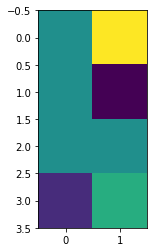

In [30]:
plt.imshow(acc_mx)
acc_mx